I used Colab to run the training on a GPU.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#_ = !unzip 'drive/MyDrive/wild.zip'
#print('Complete')

Mounted at /content/drive
Complete


In [ ]:
#import sys
#sys.path.append('drive/MyDrive/SafariNet')

In [ ]:
from model import VGG16Counting
from utils import train

## Initial Training

In [ ]:
# Dataloaders
from dataset import ClassifyCountDataset
from torch.utils.data import DataLoader

train_dataset = ClassifyCountDataset(dataset_type = 'train', img_size = 128)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ClassifyCountDataset(dataset_type = 'val', img_size = 128)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import numpy as np
import os

torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = VGG16Counting(num_classes=6, add_se=True).to(device)
save_path = 'drive/MyDrive/SafariNet/Iteration2'
os.makedirs(save_path, exist_ok = True)

In [ ]:
roc_aucs_by_epoch, mses_by_epoch = train(model2,
                                         train_dataloader,
                                         val_dataloader,
                                         save_path=save_path)
np.save(save_path + '/aurocs.npy', roc_aucs_by_epoch)
np.save(save_path + '/mses.npy', mses_by_epoch)

Epoch: 1
Average precision by class: [0.706, 0.746, 0.989, 0.822, 0.759, 0.932]
Mean Relative Root Mean Squared Error: 0.5549
Epoch: 2
Average precision by class: [0.707, 0.754, 0.973, 0.877, 0.753, 0.966]
Mean Relative Root Mean Squared Error: 0.5213
Epoch: 3
Average precision by class: [0.931, 0.765, 0.989, 0.844, 0.63, 0.948]
Mean Relative Root Mean Squared Error: 0.5187
Epoch: 4
Average precision by class: [0.988, 0.872, 0.988, 0.879, 0.552, 0.851]
Mean Relative Root Mean Squared Error: 0.5439
Epoch: 5
Average precision by class: [0.816, 0.792, 0.964, 0.84, 0.792, 0.983]
Mean Relative Root Mean Squared Error: 0.4831
Epoch: 6
Average precision by class: [0.863, 0.783, 0.989, 1.0, 0.665, 0.969]
Mean Relative Root Mean Squared Error: 0.5072
Epoch: 7
Average precision by class: [0.881, 0.907, 0.979, 0.944, 0.583, 0.978]
Mean Relative Root Mean Squared Error: 0.4975
Epoch: 8
Average precision by class: [0.702, 0.903, 0.989, 0.906, 0.768, 0.978]
Mean Relative Root Mean Squared Error: 0.4

## Determining Optimal Epoch for Full Train-Validation Training

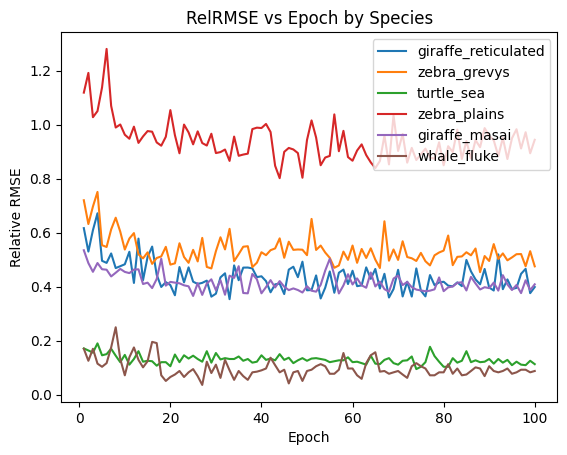

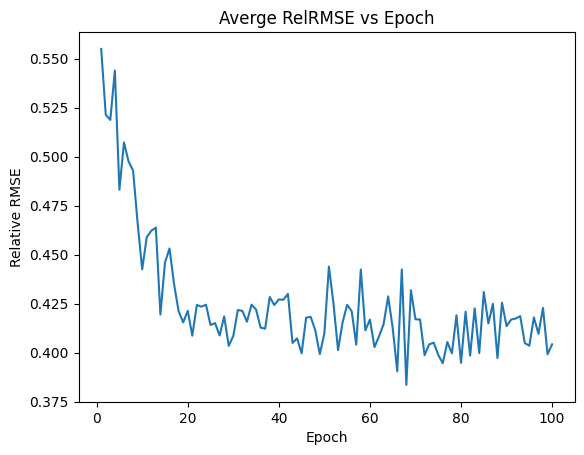

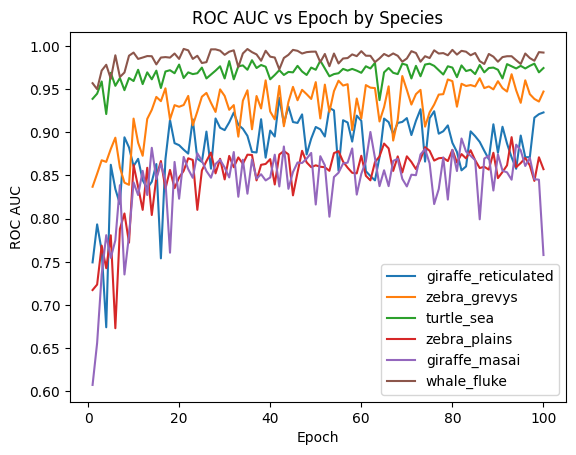

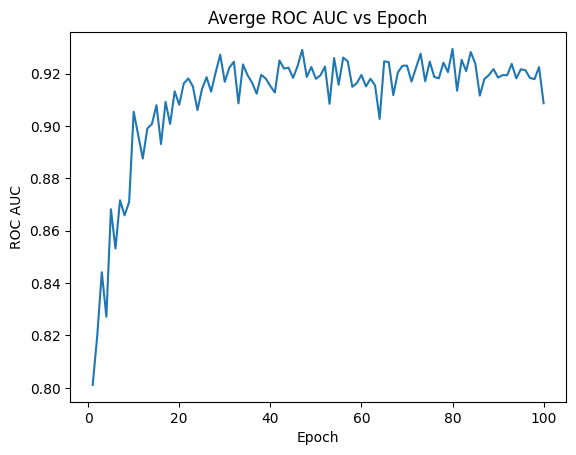

In [ ]:
from utils import epoch_graphs
epoch_graphs(roc_aucs_by_epoch, mses_by_epoch)

Average RelRMSE drops until about epoch 20 and then gently falls until around epoch 80. Average ROC AUC increases quickly until about epoch 20 and then slowly increases until around epoch 50. Because counting is our main task, we'll choose 80 for the number of epochs to train our champion model.

## Training on Full Train-Val Dataset

In [ ]:
# Create dataloader
nontest_dataset = ClassifyCountDataset(dataset_type = 'trainval', img_size = 128)
test_dataset = ClassifyCountDataset(dataset_type = 'test', img_size = 128)

nontest_dataloader = DataLoader(nontest_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bestmodel2 = VGG16Counting(num_classes=6, add_se=True).to(device)

In [ ]:
champ_num_epochs = 80
save_path = 'drive/MyDrive/SafariNet/Iteration2Test'
os.makedirs(save_path, exist_ok = True)
roc_aucs_on_test, relrmses_on_test = train(bestmodel2, nontest_dataloader,
                                           test_dataloader, num_epochs=champ_num_epochs,
                                           save_path=save_path)


Epoch: 1
Average precision by class: [0.862, 0.78, 0.969, 0.941, 0.663, 0.913]
Mean Relative Root Mean Squared Error: 0.6108
Epoch: 2
Average precision by class: [0.868, 0.757, 0.989, 0.927, 0.681, 0.969]
Mean Relative Root Mean Squared Error: 0.5552
Epoch: 3
Average precision by class: [0.891, 0.854, 0.984, 0.598, 0.781, 0.965]
Mean Relative Root Mean Squared Error: 0.5668
Epoch: 4
Average precision by class: [0.825, 0.926, 0.975, 0.834, 0.739, 0.974]
Mean Relative Root Mean Squared Error: 0.5334
Epoch: 5
Average precision by class: [0.938, 0.784, 0.984, 0.783, 0.765, 0.979]
Mean Relative Root Mean Squared Error: 0.4723
Epoch: 6
Average precision by class: [0.826, 0.892, 0.989, 0.737, 0.856, 0.917]
Mean Relative Root Mean Squared Error: 0.4692
Epoch: 7
Average precision by class: [0.902, 0.923, 0.984, 0.849, 0.751, 0.96]
Mean Relative Root Mean Squared Error: 0.4878
Epoch: 8
Average precision by class: [0.865, 0.841, 0.985, 0.783, 0.831, 0.985]
Mean Relative Root Mean Squared Error: 0

In [ ]:
from utils import display_results
# Displaying Test Scores
final_relrmses = relrmses_on_test[champ_num_epochs - 1, :]
final_roc_aucs = roc_aucs_on_test[champ_num_epochs - 1, :]
display_results(final_relrmses, final_roc_aucs)

RelRMSE = 0.34  &  AUROC = 0.94  <--  giraffe_reticulated
RelRMSE = 0.52  &  AUROC = 0.96  <--  zebra_grevys
RelRMSE = 0.08  &  AUROC = 0.99  <--  turtle_sea
RelRMSE = 0.84  &  AUROC = 0.87  <--  zebra_plains
RelRMSE = 0.45  &  AUROC = 0.86  <--  giraffe_masai
RelRMSE = 0.1  &  AUROC = 1.0  <--  whale_fluke
RelRMSE = 0.39  &  AUROC = 0.94  <--  average
